### Import des librairies et du fichier

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import folium

from collections import Counter
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

#On s'intéresse à la base uber pour le mois d'août 2014
df = pd.read_csv("uber-raw-data-aug14.csv")

### Visualisation de la base de données

In [11]:
df.head()

,Date/Time,Lat,Lon,Base
0,8/1/2014 0:03:00,40.7366,-73.9906,B02512
1,8/1/2014 0:09:00,40.7260,-73.9918,B02512
2,8/1/2014 0:12:00,40.7209,-74.0507,B02512
3,8/1/2014 0:12:00,40.7387,-73.9856,B02512
4,8/1/2014 0:12:00,40.7323,-74.0077,B02512


In [12]:
#Nous avons 829 275 observations 
df.shape

(829275, 4)

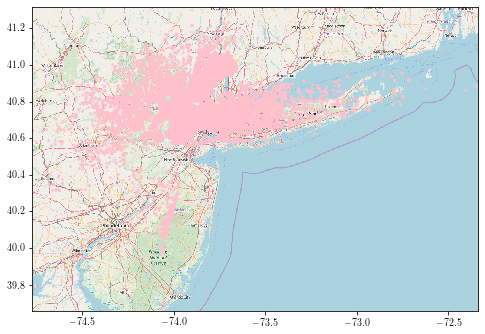

In [13]:
#Nous nous situons dans la région de New York 
plt.rc('text', usetex=True)
BBox = (df['Lon'].min(), df['Lon'].max(), df['Lat'].min(), df['Lat'].max())
ruh_m = plt.imread('map.png')
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df.Lon, df.Lat, zorder=1, alpha= 1, s=10, c='pink', marker='.')
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

Le 4ème jour de la semaine et les soirées donnent lieu à plus de courses


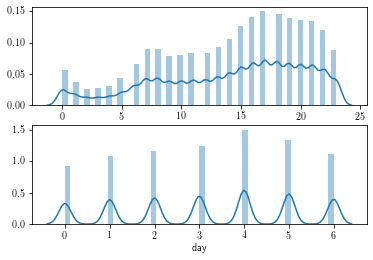

In [14]:
#Transformation de la variable Date/Time au format date et récupération du jour de la semaine et de l'heure
df['Date/Time'] =  pd.to_datetime(df['Date/Time'])
df['day'] = df['Date/Time'].dt.dayofweek
df['hour'] = df['Date/Time'].dt.hour

plt.subplot(2, 1, 1)
sns.distplot(df.hour)
plt.subplot(2, 1, 2)
sns.distplot(df.day)
print('Le {}ème jour de la semaine et les soirées donnent lieu à plus de courses'.format(Counter(df['day']).most_common(1)[0][0]))

## Déterminer le nombre optimum de clusters

In [15]:
df1 = df[['Lat', 'Lon']]

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

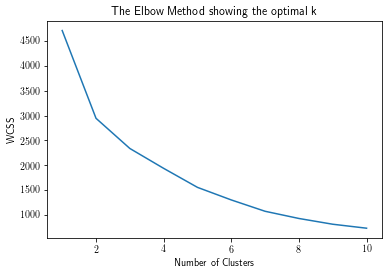

In [16]:
#Méthode Elbow avec wcss
wcss =  []
for i in range (1,11): 
    kmeans = KMeans(n_clusters= i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(df1)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('The Elbow Method showing the optimal k')

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

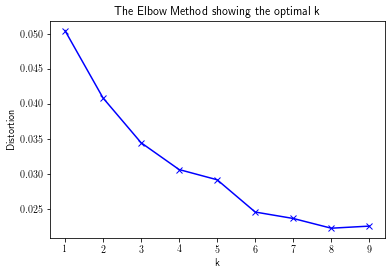

In [17]:
#Méthode Elbow avec distorsion
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,init = 'k-means++').fit(df1)
    kmeanModel.fit(df1)
    distortions.append(sum(np.min(cdist(df1, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df1.shape[0])
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.56376469026194
For n_clusters = 6 The average silhouette_score is : 0.4504666294372765


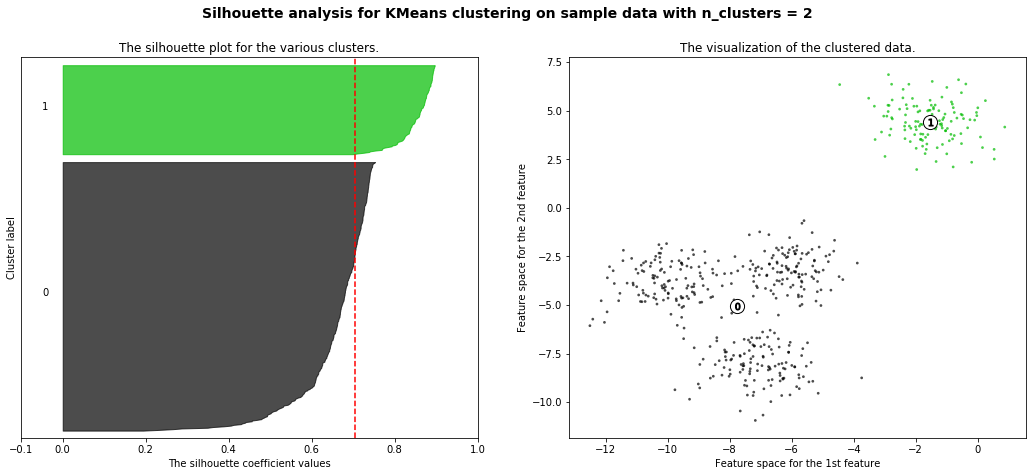

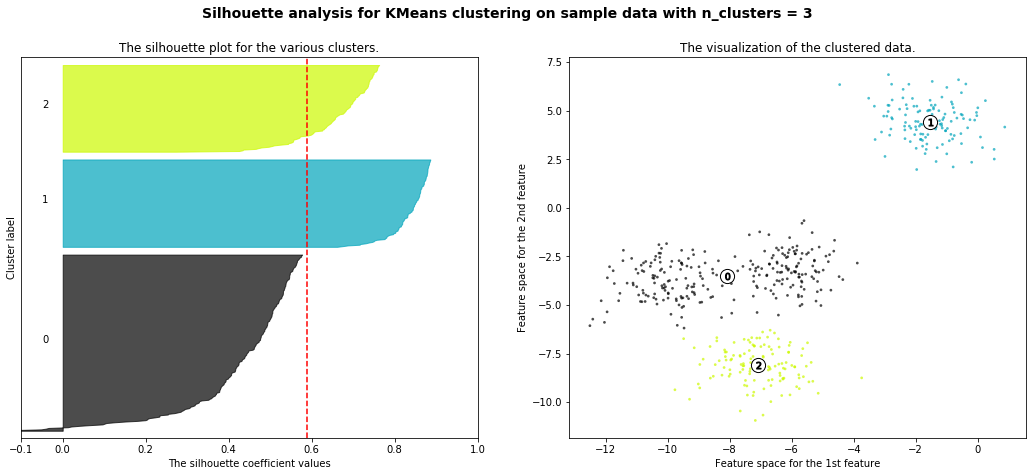

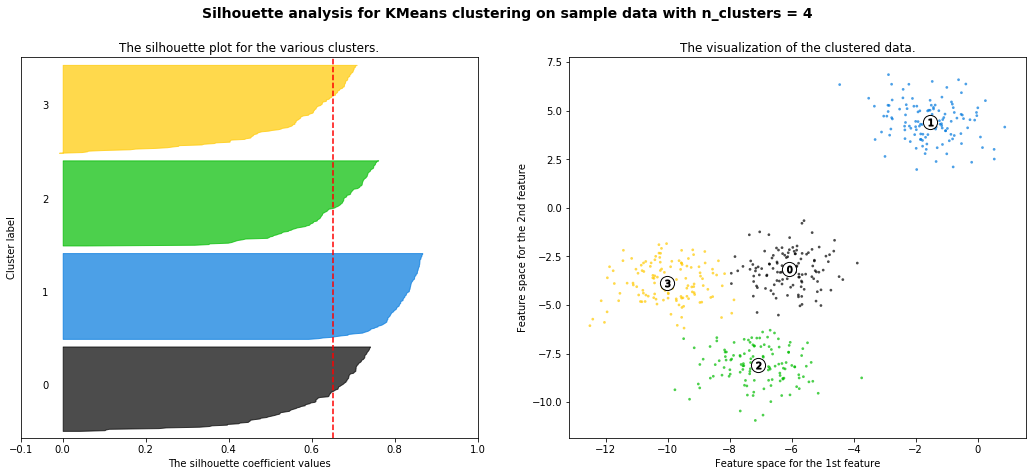

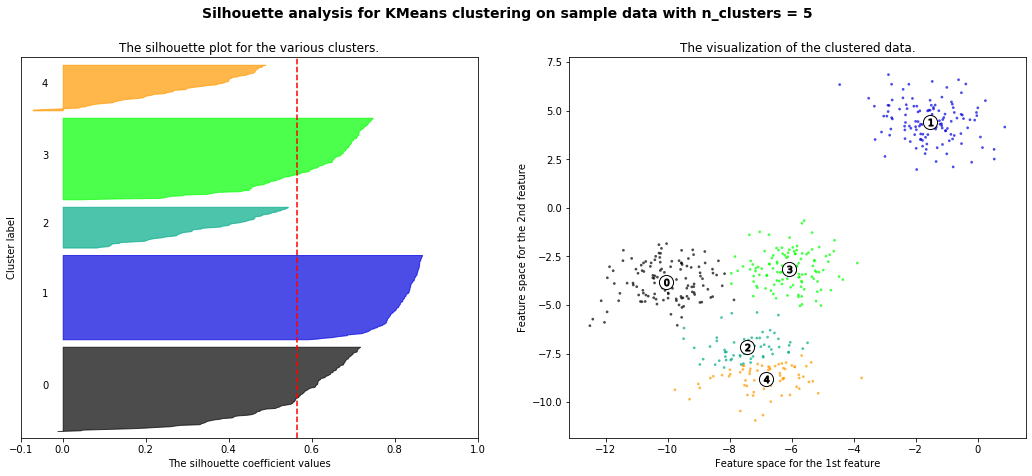

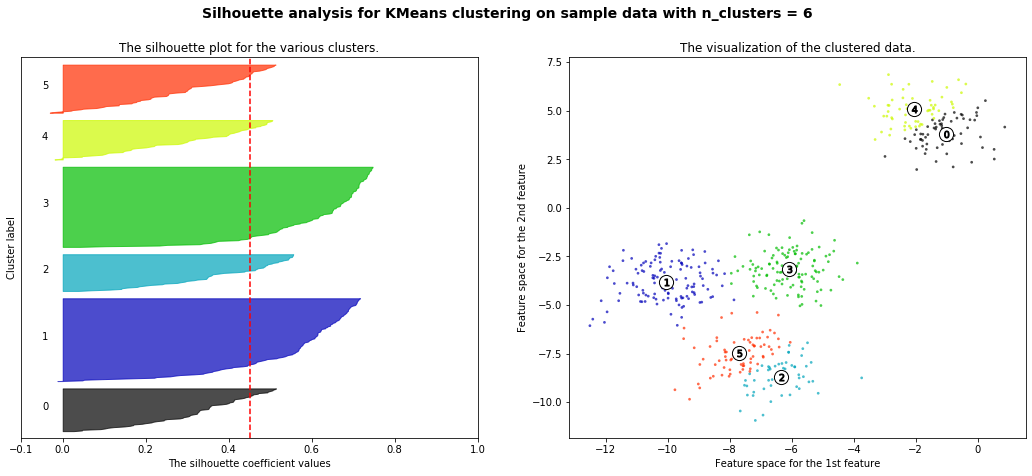

In [17]:
#Méthode Silhouette 
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1) 

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df1) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df1)
    silhouette_avg = silhouette_score(df1, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)


    sample_silhouette_values = silhouette_samples(df1, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(df1[:, 0], df1[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_

    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

### Entrainement du K-means avec 4 clusters 

In [18]:
#Entrainement du modèle et prédictions 
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeanModel.fit(df1)
cluster = kmeans.fit_predict(df1)

In [19]:
#Récupération des prédictions dans un DataFrame + concaténation
cluster = pd.DataFrame(cluster)
cluster.columns = ['Cluster']
df2 = pd.concat([cluster['Cluster'],df1],axis=1)

#récupération des centres des clusters 
centers = kmeans.cluster_centers_
centers

array([[ 40.70760168, -73.99168407],
       [ 40.75800269, -73.98053992],
       [ 40.66871906, -73.75832104],
       [ 40.7968767 , -73.88755367]])

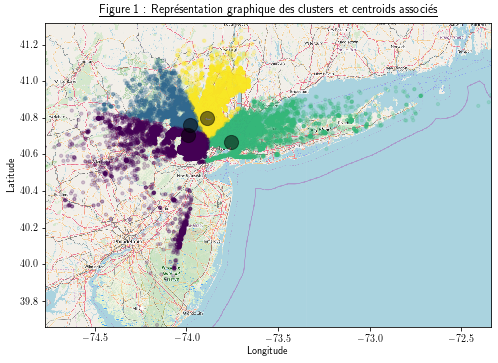

In [20]:
#Visualisation des clusters et centroids associés 
plt.rc('text', usetex=True)
BBox = (df['Lon'].min(), df['Lon'].max(), df['Lat'].min(), df['Lat'].max())
ruh_m = plt.imread('map.png')

fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df2.Lon, df2.Lat, zorder=1, alpha= 0.2, s=10, c = df2['Cluster'])
ax.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(r'\underline{Figure 1 : Représentation graphique des clusters et centroids associés}')
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

In [ ]:
#Heatmap de l'ensemble du mois avec les centroids

def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

df['count'] = 1
base_map_k = generateBaseMap()
HeatMap(data=df[['Lat', 'Lon', 'count']].groupby(['Lat', 'Lon']).sum().reset_index().values.tolist(), radius=8, min_opacity=0.1,max_zoom=13).add_to(base_map_k)

for coord in centers:
  folium.CircleMarker(location=([ coord[0], coord[1] ]), radius=10,color='darkblue',fill_color='darkblue').add_to(base_map_k)

base_map_k

In [ ]:
#Evolution des courses selon l'heure du jour ou de la nuit avec les centroids
df_hour_list = []
for hour in df.hour.sort_values().unique():
    df_hour_list.append(df.loc[df.hour == hour, ['Lat', 'Lon','count']].groupby(['Lat', 'Lon']).sum().reset_index().values.tolist())

base_map_time_k = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map_time_k)

for coord in centers:
  folium.CircleMarker(location=([ coord[0], coord[1] ]), radius=10,color='darkblue',fill_color='darkblue').add_to(base_map_time_k)

base_map_time_k

### Entrainement d'un modèle DBSCAN

In [23]:
#Restriction Dataset :nNous créons meilleur course sur la base de nos précédentes observations (jeudi et 17h)
meilleure_course = df.loc[(df['day']== 4) & (df['hour'] == 17)]
meilleure_course = meilleure_course.iloc[:,1:3]

#On choisit 5 mètres entre chaque localisation et 5 courses minimum afin de constituer un point
dbsc = DBSCAN(eps = 0.005, min_samples = 5).fit(meilleure_course)
dbsc_predict = dbsc.fit_predict(meilleure_course)
coord_dbsc = dbsc.components_

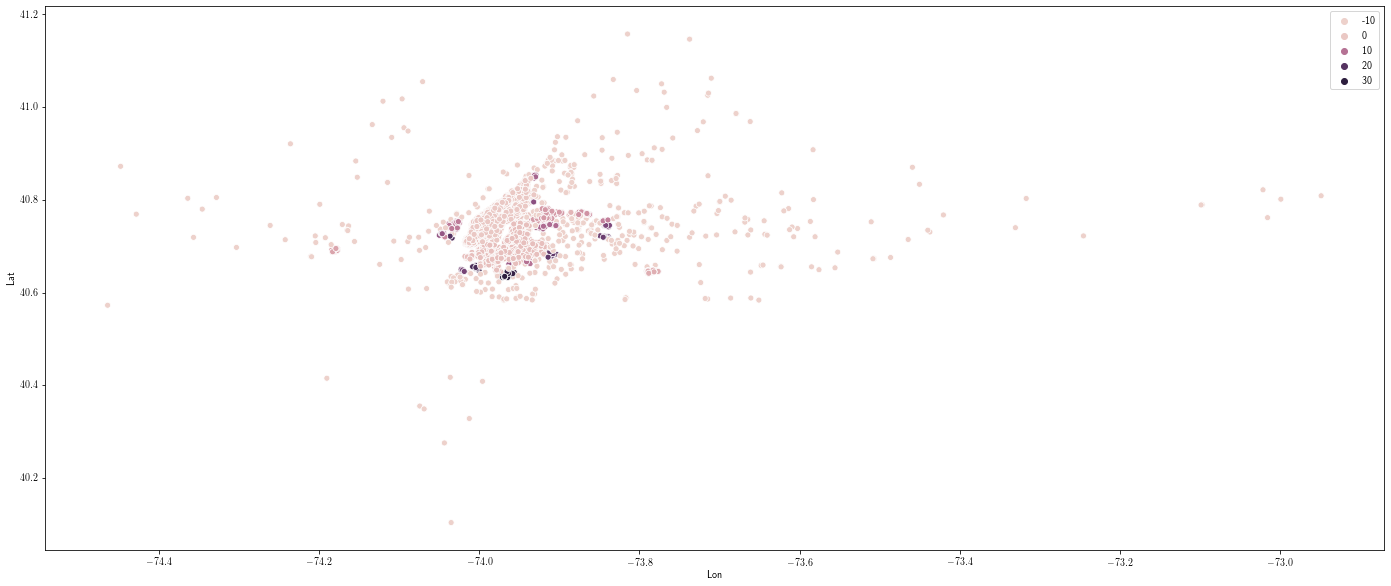

In [24]:
#Visualisation des clusters et outliers 
plt.figure(figsize=(24, 10))
sns.scatterplot(meilleure_course.iloc[:,1], meilleure_course.iloc[:, 0],hue = dbsc_predict)